In [1]:
import numpy as np
import random
from PIL import Image
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from dataset import CakeDataset
from model import Generator
from helper_functions import load_checkpoint

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device("mps")

## Generator from best epoch

In [4]:
best_epoch = 1750
log_dir = "training_resumed_logs"
checkpoint = load_checkpoint(log_dir, best_epoch)

In [5]:
generator = Generator().to(device)
generator.load_state_dict(checkpoint["generator"])
generator.eval()

Generator(
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (transp_conv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transp_conv2): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transp_conv3): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (conv_final): Conv2d(512, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation_final): Tanh()
)

## Helper functions

In [6]:
def plot_single_image(image, title="Generated Image"):
    plt.figure(figsize=(4, 4))
    img_np = (image.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)  # Scale to [0, 1]
    plt.imshow(img_np)
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_images(images, title="Generated Images"):
    plt.figure(figsize=(12, 6))
    num_images = len(images)
    for i, (img, step) in enumerate(zip(images[::num_images // 10], range(0, num_images, num_images // 10))):
        plt.subplot(2, 5, i + 1)
        img_np = (img.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)  # Scale to [0, 1]
        plt.imshow(img_np)
        plt.title(f"Step {step}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


def optimize_latent_vector(generator, target_image, latent_vector, steps=200, lr=0.01, momentum=0.9):
    # Display the target image
    plt.figure(figsize=(4, 4))
    target_img_np = (target_image.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)
    plt.imshow(target_img_np.cpu().numpy())
    plt.axis("off")
    plt.title("Target Image")
    plt.show()
    
    latent_vector = latent_vector.to(device)
    latent_vector.requires_grad = True
    criterion = torch.nn.MSELoss()
    optimizer = optim.SGD([latent_vector], lr=lr, momentum=momentum)
    generated_images = []
    latent_vectors = [latent_vector.detach().cpu().clone()]
    loss_values = []
    
    for _ in range(steps):
        optimizer.zero_grad()
        generated_image = generator(latent_vector)
        loss = criterion(generated_image, target_image)
        loss.backward()
        optimizer.step()
        generated_images.append(generated_image.detach().cpu().squeeze(0))
        loss_values.append(loss.item())

    latent_vectors.append(latent_vector.detach().cpu().clone())
    
    # Plot loss over steps
    plt.figure(figsize=(8, 4))
    plt.plot(loss_values, label="MSE Loss")
    plt.xlabel("Optimization Step")
    plt.ylabel("Loss")
    plt.title("Loss Over Time During Latent Vector Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

    return latent_vector.detach().cpu(), generated_images, latent_vectors


def plot_latent_vectors(latent_vectors, title="Latent Vector Evolution"):
    plt.figure(figsize=(10, 6))
    for i, latent_vector in enumerate(latent_vectors):
        if i == 0:
            label = f"First latent vector"
            linewidth = 1
        else:
            label = f"Last (optimized) latent vector"
            linewidth = 0.5
        
        plt.plot(range(len(latent_vector[0])), latent_vector[0], marker='o', linestyle='-', label=label, linewidth=linewidth)

    plt.xlabel("Index in Latent Vector")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## First target image - finding similar latent vector

In [7]:
data_path = "crawled_cakes"
dataset = CakeDataset(data_path)

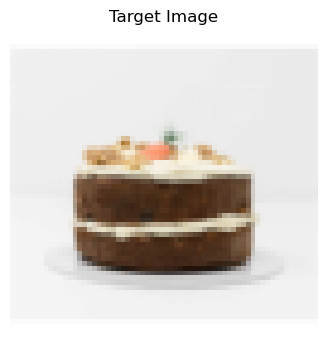

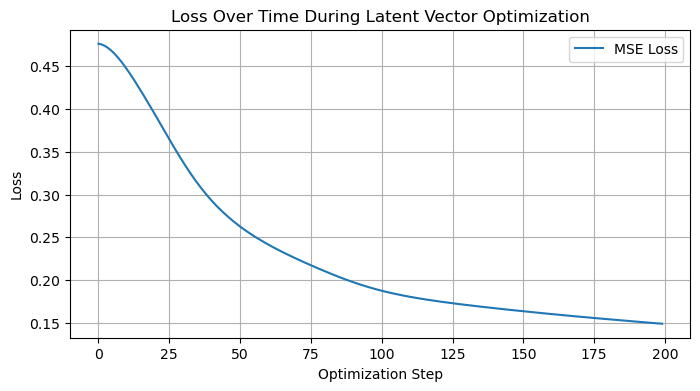

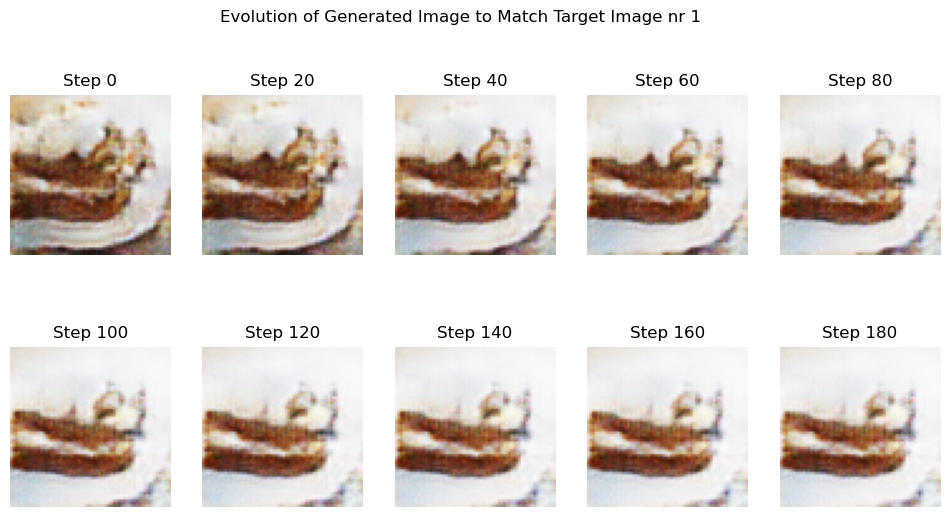

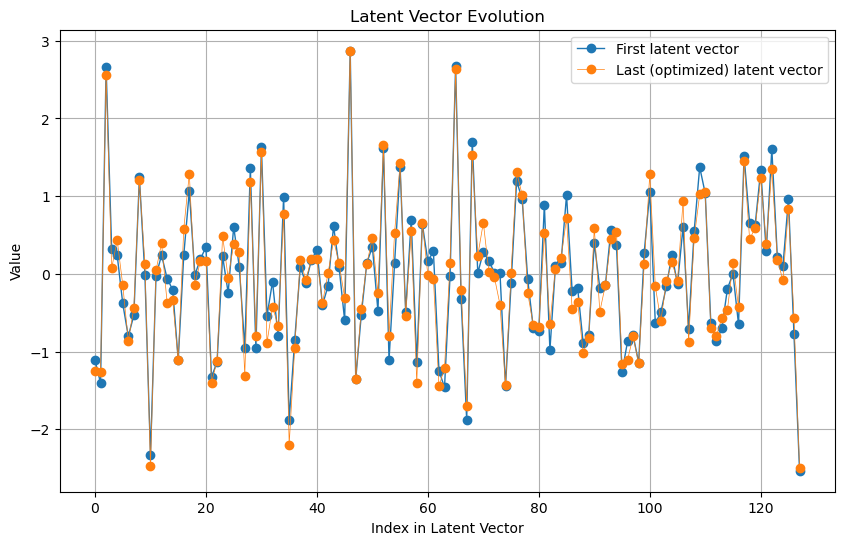

In [8]:
target_idx = 7
target_image = dataset[target_idx].unsqueeze(0).to(device)  # Shape [1, C, H, W]

# Optimize latent vector - make similar to target image (find similar latent vector)
latent_vector_first = torch.randn(1, generator.noise_dim).to(device)
optimized_latent_vector_first, generated_images_first, latent_vectors_first = optimize_latent_vector(generator, target_image, latent_vector_first)
plot_images(generated_images_first, title="Evolution of Generated Image to Match Target Image nr 1")
plot_latent_vectors(latent_vectors_first)


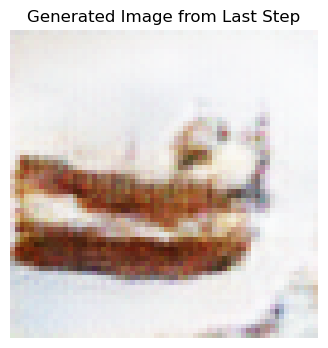

In [9]:
plot_single_image(generated_images_first[-1].detach().cpu().squeeze(0), title="Generated Image from Last Step")

## Manual modification of the optimized latent vector

In [10]:
optimized_latent_vector_first_modified = optimized_latent_vector_first.clone()

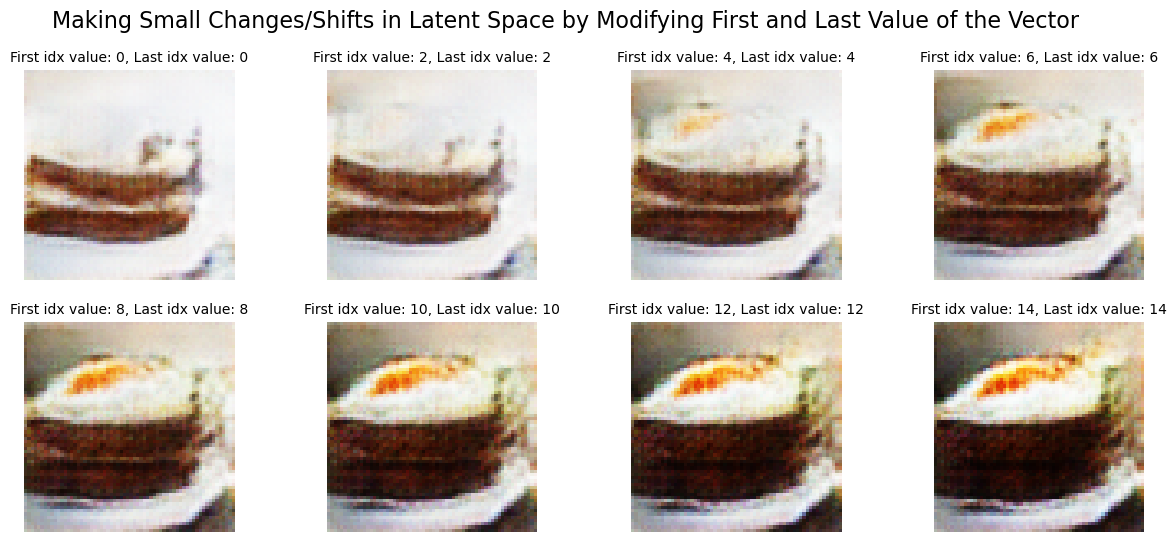

In [11]:
plt.figure(figsize=(15, 6))
plt.suptitle("Making Small Changes/Shifts in Latent Space by Modifying First and Last Value of the Vector", fontsize=16)

for idx, i in enumerate(range(0, 16, 2)):
    optimized_latent_vector_first_modified[0, 0] = i
    optimized_latent_vector_first_modified[0, -1] = i

    modified_image = generator(optimized_latent_vector_first_modified.to(device)).detach().cpu().squeeze(0)
    
    plt.subplot(2, 4, idx + 1)
    img_np = (modified_image.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"First idx value: {i}, Last idx value: {i}", fontsize=10)

plt.show()

## Second target image - finding similar latent vector

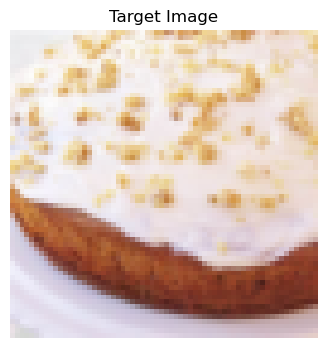

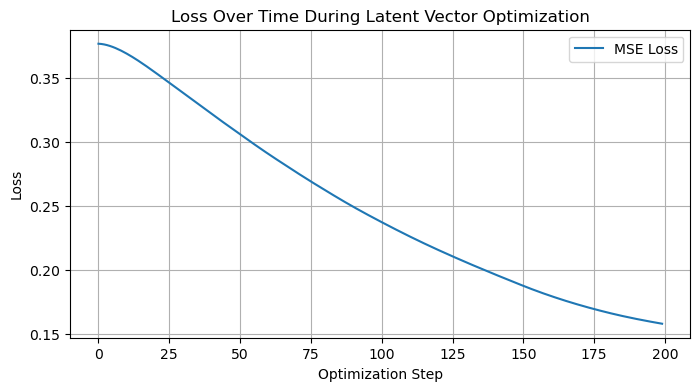

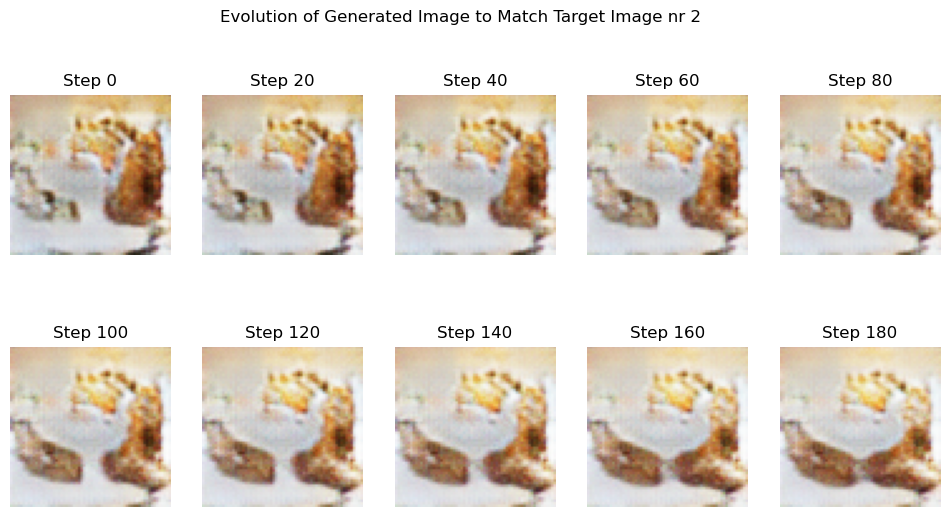

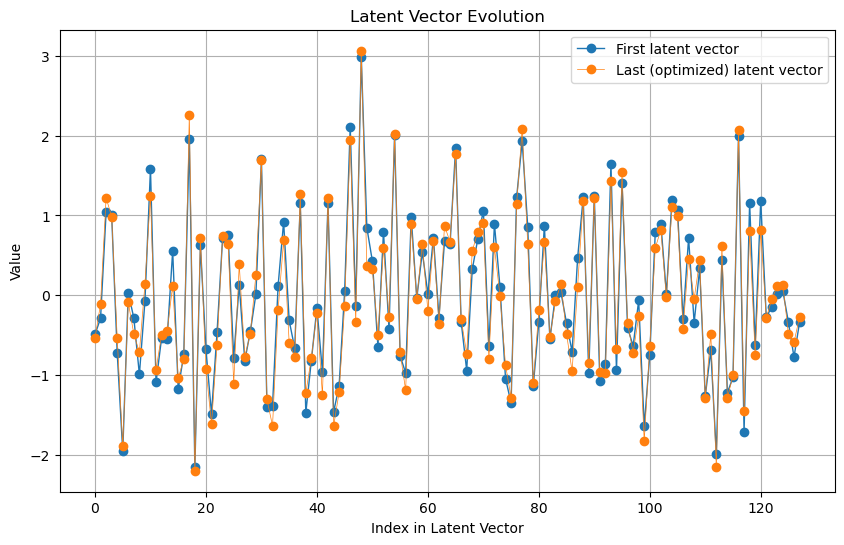

In [12]:
target_idx = 16
target_image_second = dataset[target_idx].unsqueeze(0).to(device)  # Shape [1, C, H, W]

latent_vector_second = torch.randn(1, generator.noise_dim).to(device)
optimized_latent_vector_second, generated_images_second, latent_vectors_second = optimize_latent_vector(generator, target_image_second, latent_vector_second)
plot_images(generated_images_second, title="Evolution of Generated Image to Match Target Image nr 2")
plot_latent_vectors(latent_vectors_second)


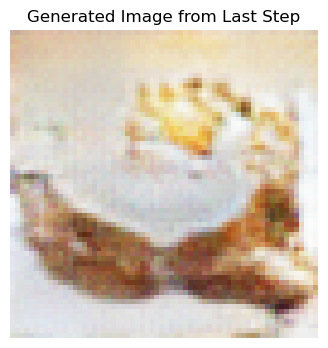

In [13]:
plot_single_image(generated_images_second[-1].detach().cpu().squeeze(0), title="Generated Image from Last Step")

## Generating intermediate images by interpolating between two latent vectors

In [14]:
interpolation_steps = 10
latent_vector_A = optimized_latent_vector_first.clone().detach()
latent_vector_B = optimized_latent_vector_second.clone().detach()

interpolations = [latent_vector_A * (1 - t) + latent_vector_B * t for t in torch.linspace(0, 1, interpolation_steps)]
interpolated_images = [generator(latent_vec.unsqueeze(0).to(device)).detach().cpu().squeeze(0) for latent_vec in interpolations]

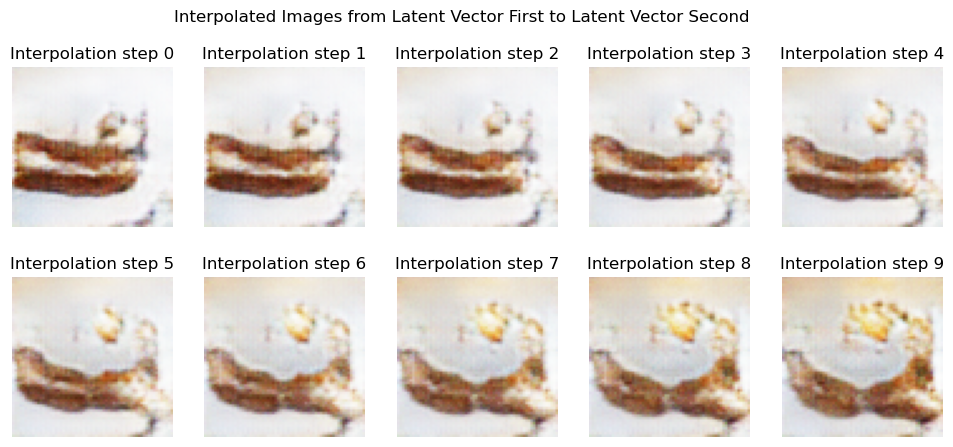

In [15]:
plt.figure(figsize=(12, 5))
for i, img in enumerate(interpolated_images):
    plt.subplot(2, 5, i + 1)
    img_np = (img.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)
    plt.imshow(img_np)
    plt.title(f"Interpolation step {i}")
    plt.axis("off")

plt.suptitle("Interpolated Images from Latent Vector First to Latent Vector Second")
plt.show()

## Unrelated image as the target image to optimize latent vector

In [16]:
unrelated_image_path = 'unrelated_image.jpg'

image_size = 64
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

unrelated_target_image = Image.open(unrelated_image_path).convert('RGB')
unrelated_target_image = transform(unrelated_target_image).unsqueeze(0).to(device)


In [17]:
latent_vector_unrelated = torch.randn(1, generator.noise_dim).to(device)

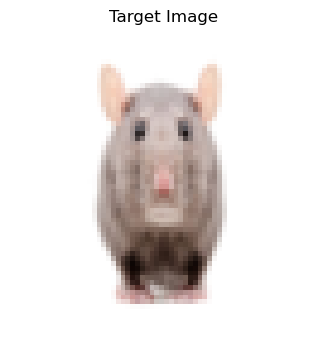

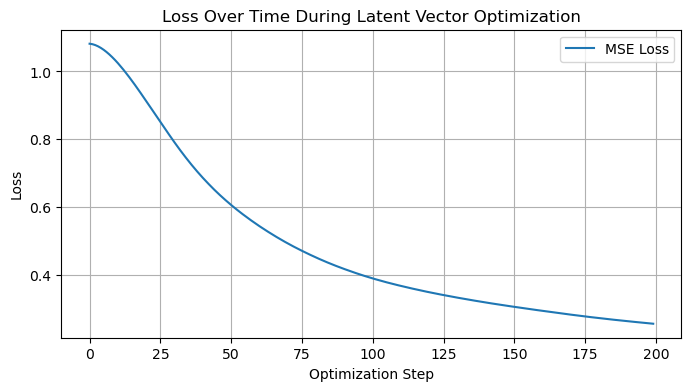

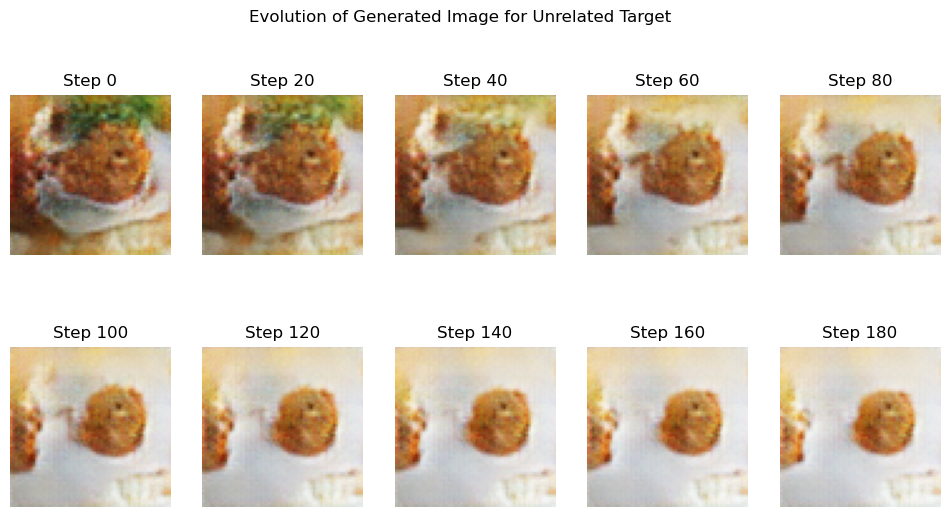

In [18]:
optimized_latent_vector_unrelated, generated_images_unrelated, latent_vectors_unrelated = optimize_latent_vector(generator, unrelated_target_image, latent_vector_unrelated)
plot_images(generated_images_unrelated, title="Evolution of Generated Image for Unrelated Target")